#### import the packages

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
sns.set(style="ticks")

#### UDFs

In [162]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [163]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [164]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

## BUSINESS PROBLEM-1
### BACKGROUND: The Lending Club is a peer-to-peer lending site where members make loans to each other. The site makes anonymized data on loans and borrowers publicly available.
## BUSINESS PROBLEM:
### Using lending club loans data, the team would like to test below hypothesis on how different factors effecing each other (Hint: You may leverage hypothesis testing using statistical tests)
### a. Intrest rate is varied for different loan amounts (Less intrest charged for high loan amounts)
### b. Loan length is directly effecting intrest rate.
### c. Inrest rate varies for different purpose of loans
### d. There is relationship between FICO scores and Home Ownership. It means that, People with owning home will have high FICO scores.

#### data import

In [165]:
 LoansData = pd.read_csv('D:/Projects/Python/Basic Statistics - Hypothesis Testing/LoansData.csv')

#### data inspection

In [166]:
LoansData.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,20000.0,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
1,19200.0,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
2,35000.0,35000.0,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
3,10000.0,9975.0,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
4,12000.0,12000.0,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years


In [167]:
LoansData.columns

Index(['Amount.Requested', 'Amount.Funded.By.Investors', 'Interest.Rate',
       'Loan.Length', 'Loan.Purpose', 'Debt.To.Income.Ratio', 'State',
       'Home.Ownership', 'Monthly.Income', 'FICO.Range', 'Open.CREDIT.Lines',
       'Revolving.CREDIT.Balance', 'Inquiries.in.the.Last.6.Months',
       'Employment.Length'],
      dtype='object')

In [168]:
# renaming the columns
LoansData.rename(columns = {'Amount.Requested' : 'Amount_Requested', 'Amount.Funded.By.Investors' : 'Amount_Funded_By_Investors',
                            'Interest.Rate' : 'Interest_Rate', 'Loan.Length' : 'Loan_Length', 'Loan.Purpose' : 'Loan_Purpose',
                            'Debt.To.Income.Ratio' : 'Debt_To_Income_Ratio', 'Home.Ownership' : 'Home_Ownership', 'Monthly.Income' : 
                            'Monthly_Income', 'FICO.Range' : 'FICO_Range', 'Open.CREDIT.Lines' : 'Open_CREDIT_Lines', 'Revolving.CREDIT.Balance' : 
                            'Revolving_CREDIT_Balance', 'Inquiries.in.the.Last.6.Months' : 'Inquiries_in_the_Last_6_Months',
                            'Employment.Length' : 'Employment_Length'}, inplace = True)

In [169]:
LoansData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Amount_Requested                2499 non-null   float64
 1   Amount_Funded_By_Investors      2499 non-null   float64
 2   Interest_Rate                   2498 non-null   object 
 3   Loan_Length                     2500 non-null   object 
 4   Loan_Purpose                    2500 non-null   object 
 5   Debt_To_Income_Ratio            2499 non-null   object 
 6   State                           2500 non-null   object 
 7   Home_Ownership                  2499 non-null   object 
 8   Monthly_Income                  2499 non-null   float64
 9   FICO_Range                      2498 non-null   object 
 10  Open_CREDIT_Lines               2497 non-null   float64
 11  Revolving_CREDIT_Balance        2497 non-null   float64
 12  Inquiries_in_the_Last_6_Months  24

In [170]:
LoansData.isna().sum()

Amount_Requested                   1
Amount_Funded_By_Investors         1
Interest_Rate                      2
Loan_Length                        0
Loan_Purpose                       0
Debt_To_Income_Ratio               1
State                              0
Home_Ownership                     1
Monthly_Income                     1
FICO_Range                         2
Open_CREDIT_Lines                  3
Revolving_CREDIT_Balance           3
Inquiries_in_the_Last_6_Months     3
Employment_Length                 77
dtype: int64

In [171]:
# converting the datatypes
LoansData.Interest_Rate = LoansData.Interest_Rate.str.replace('%', '').astype(float)
LoansData.Loan_Length = LoansData.Loan_Length.str.replace('months', '').astype(float)
LoansData.Debt_To_Income_Ratio = LoansData.Debt_To_Income_Ratio.str.replace('%', '').astype(float)

#### separate the categorical vs continuous variables

In [172]:
# creating a copy of the data
LoansData_continuous = LoansData.select_dtypes('float64')
LoansData_categorical = LoansData.select_dtypes('object')

# creating the variables with column names
LoansData_cat_variables = LoansData.select_dtypes('object').columns
LoansData_conti_variables = LoansData.select_dtypes('float64').columns

#### data summary

In [173]:
LoansData_continuous.apply(continuous_var_summary)

,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,380,710,275,2,1669,632,29,2349,10
n_tot,2500,2500,2500,2500,2500,2500,2500,2500,2500
n,2499,2499,2498,2500,2499,2499,2497,2497,2497
nmiss,1,1,2,0,1,1,3,3,3
perc_miss,0.04,0.04,0.08,0.0,0.04,0.04,0.12,0.12,0.12
sum,31001250.0,29993933.09,32637.34,103152.0,38435.67,14216639.37,25152.0,38012292.0,2264.0
mean,12405.462185,12002.374186,13.065388,41.2608,15.38042,5688.931321,10.072887,15223.184622,0.906688
std,7802.933666,7746.767348,4.177201,9.930893,7.505052,3963.118185,4.507416,18281.015258,1.231149
var,60885773.795507,60012404.344627,17.449011,98.622632,56.325811,15706305.750123,20.316801,334195518.850116,1.515728


#### outlier treatment

In [174]:
LoansData_continuous = LoansData_continuous.apply(lambda x : x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

#### missing value treatment

In [175]:
LoansData_continuous = LoansData_continuous.apply(missing_imputation)

#### summary

In [176]:
LoansData_continuous.apply(continuous_var_summary)

,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,376,692,266,2,1630,603,22,2326,7
n_tot,2500,2500,2500,2500,2500,2500,2500,2500,2500
n,2500,2500,2500,2500,2500,2500,2500,2500,2500
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,31022684.073629,30020529.731893,32650.858187,103152.0,38446.318527,14021372.19888,25135.162195,36922960.552663,2218.662395
mean,12409.073629,12008.211893,13.060343,41.2608,15.378527,5608.54888,10.054065,14769.184221,0.887465
std,7796.219717,7736.635635,4.147574,9.930893,7.478992,3083.751452,4.377253,14758.263838,1.141347
var,60781041.868928,59855530.953807,17.202371,98.622632,55.935326,9509523.019376,19.160345,217806351.516406,1.302672


#### summary of categorical variables

In [177]:
LoansData_categorical.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
Loan_Purpose,2500,0,debt_consolidation,1307,52.28
State,2500,0,CA,433,17.32
Home_Ownership,2499,1,MORTGAGE,1147,45.9
FICO_Range,2498,2,670-674,171,6.85
Employment_Length,2423,77,10+ years,653,26.95


#### combine the cat and conti variables

In [178]:
LoansData_new = pd.concat([LoansData_categorical, LoansData_continuous], axis = 1)

In [179]:
LoansData_new.shape

(2500, 14)

### a. Intrest rate is varied for different loan amounts (Less intrest charged for high loan amounts)

In [180]:
LoansData_new.columns

Index(['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range',
       'Employment_Length', 'Amount_Requested', 'Amount_Funded_By_Investors',
       'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio',
       'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


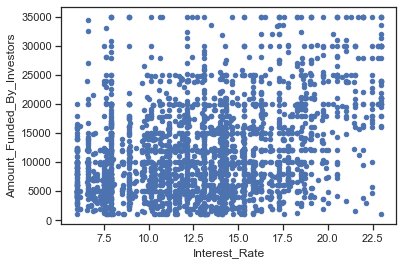

In [181]:
LoansData_new.plot(kind = 'scatter', x = 'Interest_Rate', y = 'Amount_Funded_By_Investors')
plt.show()

In [182]:
LoansData_new.loc[:, ['Interest_Rate', 'Amount_Funded_By_Investors']].corr()

,Interest_Rate,Amount_Funded_By_Investors
Interest_Rate,1.000000,0.335661
Amount_Funded_By_Investors,0.335661,1.000000


In [183]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [184]:
stats.pearsonr(LoansData_new.Interest_Rate, LoansData_new.Amount_Funded_By_Investors)

(0.3356612554420614, 6.841366109527337e-67)

In [185]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Interest rate is varied for different loan amounts.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Interest rate is varied for different loan amounts.


### b. Loan length is directly effecting intrest rate.

In [186]:
LoansData_new.columns

Index(['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range',
       'Employment_Length', 'Amount_Requested', 'Amount_Funded_By_Investors',
       'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio',
       'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


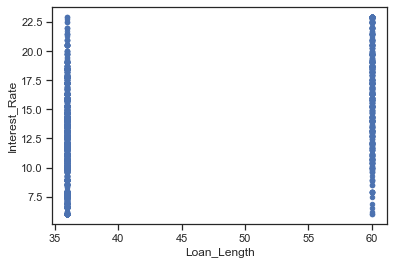

In [187]:
LoansData_new.plot(kind = 'scatter', x = 'Loan_Length', y = 'Interest_Rate')
plt.show()

In [188]:
LoansData_new.loc[:, ['Loan_Length', 'Interest_Rate']].corr()

,Loan_Length,Interest_Rate
Loan_Length,1.000000,0.423153
Interest_Rate,0.423153,1.000000


In [189]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [190]:
stats.pearsonr(LoansData_new.Loan_Length, LoansData_new.Interest_Rate)

(0.4231525105331439, 3.565010388635864e-109)

In [191]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Loan length is directly effecting interest rate.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Loan length is directly effecting interest rate.


### c. Inrest rate varies for different purpose of loans

In [192]:
LoansData_new.Loan_Purpose.nunique()

14

In [193]:
LoansData_new.Loan_Purpose.value_counts()

debt_consolidation    1307
credit_card            444
other                  201
home_improvement       152
major_purchase         101
small_business          87
car                     50
wedding                 39
medical                 30
moving                  29
vacation                21
house                   20
educational             15
renewable_energy         4
Name: Loan_Purpose, dtype: int64

In [194]:
LoansData_new.columns

Index(['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range',
       'Employment_Length', 'Amount_Requested', 'Amount_Funded_By_Investors',
       'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio',
       'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months'],
      dtype='object')

In [195]:
interest_rate = 'Interest_Rate'

# filter the data based on loan purpose
lp_1 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'debt_consolidation', interest_rate]
lp_2 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'credit_card', interest_rate]
lp_3 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'other', interest_rate]
lp_4 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'home_improvement', interest_rate]
lp_5 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'major_purchase', interest_rate]
lp_6 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'small_business', interest_rate]
lp_7 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'car', interest_rate]
lp_8 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'wedding', interest_rate]
lp_9 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'medical', interest_rate]
lp_10 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'moving', interest_rate]
lp_11 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'vacation', interest_rate]
lp_12 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'house', interest_rate]
lp_13 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'educational', interest_rate]
lp_14 = LoansData_new.loc[LoansData_new.Loan_Purpose == 'renewable_energy', interest_rate]

print('mean of lp_1: ', lp_1.mean(), '| mean of lp_2: ', lp_2.mean(), '| mean of lp_3: ', lp_3.mean(),
      '| mean of lp_4: ', lp_4.mean(), '| mean of lp_5: ', lp_5.mean(), '| mean of lp_6: ', lp_6.mean(),
      '| mean of lp_7: ', lp_7.mean(), '| mean of lp_8: ', lp_8.mean(), '| mean of lp_9: ', lp_9.mean(),
      '| mean of lp_10: ', lp_10.mean(), '| mean of lp_11: ', lp_11.mean(), '| mean of lp_12: ', lp_12.mean(),
      '| mean of lp_13: ', lp_13.mean(), '| mean of lp_14: ', lp_14.mean())

mean of lp_1:  13.576203749043632 | mean of lp_2:  13.047648746113989 | mean of lp_3:  13.157332338308455 | mean of lp_4:  11.615381578947373 | mean of lp_5:  10.805326732673265 | mean of lp_6:  12.841425287356316 | mean of lp_7:  11.116880000000002 | mean of lp_8:  12.087547263451793 | mean of lp_9:  11.657796666666671 | mean of lp_10:  13.533579310344832 | mean of lp_11:  11.993047619047621 | mean of lp_12:  13.448000000000002 | mean of lp_13:  11.007333333333332 | mean of lp_14:  9.8775


In [196]:
# H0: All samples are from same population, means are equal
# Ha: All samples are from different population, means are unequal
# CI: 95%, p: 0.05

In [197]:
stats.f_oneway(lp_1, lp_2, lp_3, lp_4, lp_5, lp_6, lp_7, lp_8, lp_9, lp_10, lp_11, lp_12, lp_13, lp_14)

F_onewayResult(statistic=7.425396084031361, pvalue=1.5948691989570564e-14)

In [198]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Interest rate varies for different purpose of loans.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means Interest rate varies for different purpose of loans.


### d. There is relationship between FICO scores and Home Ownership. It means that, People with owning home will have high FICO scores.

In [199]:
LoansData_new.columns

Index(['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range',
       'Employment_Length', 'Amount_Requested', 'Amount_Funded_By_Investors',
       'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio',
       'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance',
       'Inquiries_in_the_Last_6_Months'],
      dtype='object')

In [200]:
obs_freq = pd.crosstab(LoansData_new.FICO_Range, LoansData_new.Home_Ownership)
obs_freq

Home_Ownership,MORTGAGE,NONE,OTHER,OWN,RENT
FICO_Range,,,,,
640-644,0,0,0,1,4
645-649,1,0,0,0,2
650-654,1,0,0,0,0
655-659,0,0,1,0,3
660-664,41,0,0,17,67
665-669,52,0,0,18,75
670-674,67,0,1,13,90
675-679,79,0,1,11,75
680-684,55,0,2,9,91


In [201]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [202]:
stats.chi2_contingency(obs_freq)

(473.05246368346025,
 1.2021592010244615e-35,
 148,
 array([[2.29475370e+00, 2.00240288e-03, 1.00120144e-02, 4.00480577e-01,
         2.29275130e+00],
        [1.37685222e+00, 1.20144173e-03, 6.00720865e-03, 2.40288346e-01,
         1.37565078e+00],
        [4.58950741e-01, 4.00480577e-04, 2.00240288e-03, 8.00961153e-02,
         4.58550260e-01],
        [1.83580296e+00, 1.60192231e-03, 8.00961153e-03, 3.20384461e-01,
         1.83420104e+00],
        [5.73688426e+01, 5.00600721e-02, 2.50300360e-01, 1.00120144e+01,
         5.73187825e+01],
        [6.65478574e+01, 5.80696836e-02, 2.90348418e-01, 1.16139367e+01,
         6.64897877e+01],
        [7.84805767e+01, 6.84821786e-02, 3.42410893e-01, 1.36964357e+01,
         7.84120945e+01],
        [7.61858230e+01, 6.64797757e-02, 3.32398879e-01, 1.32959551e+01,
         7.61193432e+01],
        [7.20552663e+01, 6.28754505e-02, 3.14377253e-01, 1.25750901e+01,
         7.19923909e+01],
        [6.24173008e+01, 5.44653584e-02, 2.72326792e-01, 

In [203]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means There is relationship between FICO scores and Home Ownership.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means There is relationship between FICO scores and Home Ownership.


## BUSINESS PROBLEM - 2
### BACKGROUND: When an order is placed by a customer of a small manufacturing company, a price quote must be developed for that order. Because each order is unique, quotes must be established on an order-by-order basis by a pricing expert. The price quote process is laborintensive, as prices depend on many factors such as the part number, customer, geographic location, market, and order volume. The sales department manager is concerned that the pricing process is too complex, and that there might be too much variability in the quoted prices. An improvement team is tasked with studying and improving the pricing process. After interviewing experts to develop a better understanding of the current process, the team designed a study to determine if there is variability between pricing experts. That is, do different pricing experts provide different price quotes? Two randomly selected pricing experts, Mary and Barry, were asked to independently provide prices for twelve randomly selected orders. Each expert provided one price for each of the twelve orders.
### BUSINESS PROBLEM: We would like to assess if there is any difference in the average price quotes provided by Mary and Barry.

#### data import

In [204]:
Price_Quotes = pd.read_csv('D:/Projects/Python/Basic Statistics - Hypothesis Testing/Price_Quotes.csv')
Price_Quotes

,Order_Number,Barry_Price,Mary_Price
0,1,126,114
1,2,110,118
2,3,138,114
3,4,142,111
4,5,146,129
5,6,136,119
6,7,94,97
7,8,103,104
8,9,140,127
9,10,152,133


### We would like to assess if there is any difference in the average price quotes provided by Mary and Barry.

In [205]:
Price_Quotes.columns

Index(['Order_Number', 'Barry_Price', 'Mary_Price'], dtype='object')

In [206]:
# print the means
print('Mary price mean: ', Price_Quotes.Mary_Price.mean())
print('Barry price mean: ', Price_Quotes.Barry_Price.mean())

Mary price mean:  114.75
Barry price mean:  124.33333333333333


In [207]:
# H0: u1 = u2
# Ha: u1 <> u2
# CI: 95%, p: 0.05

In [208]:
stats.ttest_rel(Price_Quotes.Mary_Price, Price_Quotes.Barry_Price)

Ttest_relResult(statistic=-2.521376510892349, pvalue=0.02840588045242053)

In [209]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means There is difference in the average price quotes provided by Mary and Barry.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means There is difference in the average price quotes provided by Mary and Barry.


## BUSINESS PROBLEM-3:
### BACKGROUND: The New Life Residential Treatment Facility is a NGO that treats teenagers who have shown signs of mental illness. It provides housing and supervision of teenagers who are making the transition from psychiatric hospitals back into the community. Because many of the teenagers were severely abused as children and have been involved with the juvenile justice system, behavioral problems are common at New Life. Employee pay is low and staff turnover (attrition) is high.
### A reengineering program was instituted at New Life with the goals of lowering behavioral problems of the kids and decreasing employee turnover rates. As a part of this effort, the following changes were made:
###  Employee shifts were shortened from 10 hours to 8 hours each day.
###  Employees were motivated to become more involved in patient treatments. This included encouraging staff to run various therapeutic treatment sessions and allowing staff to have more say in program changes.
###  The activities budget was increased.
###  A facility-wide performance evaluation system was put into place that rewarded staff participation and innovation.
###  Management and staff instituted a program designed to raise expectations about appropriate behavior from the kids. This included strict compliance with reporting of behavioral violations, insistence on participation in therapeutic sessions, and a lowered tolerance for even moderate behavioral infractions.
### To determine the effectiveness of the reengineering effort, a data set comprised of pre- and post-reengineering periods was compiled. The information contains two measures of behavioral problems. A critical incident occurs when a resident goes AWOL (leaves the premises without permission), destroys property (e.g., punching a hole in a wall or throwing furniture through windows), is caught in possession of street drugs, or engages in assault against other residents or staff members. A teenager is temporarily removed from the facility when s/he is sent to jail or back to a psychiatric hospital
### BUSINESS PROBLEM: Determine what effect, if any, the reengineering effort had on the incidence behavioral problems and staff turnover. i.e To determine if the reengineering effort changed the critical incidence rate. Is there evidence that the critical incidence rate improved?

#### data import

In [210]:
Treatment_Facility = pd.read_csv('D:/Projects/Python/Basic Statistics - Hypothesis Testing/Treatment_Facility.csv')
Treatment_Facility

,Month,Reengineer,Employee_Turnover,VAR4,VAR5
0,1,Prior,0.0000,24.390244,42.682927
1,2,Prior,6.0606,19.354839,25.806452
2,3,Prior,12.1212,35.087719,146.198830
3,4,Prior,3.3333,18.404908,110.429448
4,5,Prior,12.9032,17.964072,23.952096
5,6,Prior,9.6774,41.176471,47.058824
6,7,Prior,11.7647,13.422819,0.000000
7,8,Prior,11.4286,31.250000,25.000000
8,9,Prior,23.0769,17.241379,132.183908
9,10,Prior,15.0000,16.574586,16.574586


#### data inspection

In [211]:
Treatment_Facility.columns

Index(['Month', 'Reengineer', 'Employee_Turnover', 'VAR4', 'VAR5'], dtype='object')

In [212]:
# renaming the columns
Treatment_Facility.rename(columns = {'VAR4' : 'TRFF', 'VAR5' : 'CI'}, inplace = True)
Treatment_Facility.head(2)

,Month,Reengineer,Employee_Turnover,TRFF,CI
0,1,Prior,0.0000,24.390244,42.682927
1,2,Prior,6.0606,19.354839,25.806452


### Determine what effect, if any, the reengineering effort had on the incidence behavioral problems and staff turnover. i.e To determine if the reengineering effort changed the critical incidence rate. Is there evidence that the critical incidence rate improved?

In [213]:
Treatment_Facility.Reengineer.value_counts()

Prior    13
Post      7
Name: Reengineer, dtype: int64

In [214]:
Treatment_Facility.columns

Index(['Month', 'Reengineer', 'Employee_Turnover', 'TRFF', 'CI'], dtype='object')

In [215]:
CI_rate = 'CI'
prior = Treatment_Facility.loc[Treatment_Facility.Reengineer == 'Prior', CI_rate]
post = Treatment_Facility.loc[Treatment_Facility.Reengineer == 'Post', CI_rate]

print('mean of prior: ', prior.mean())
print('mean of post: ', post.mean())

mean of prior:  53.887906321846145
mean of post:  23.34971927988571


In [216]:
# H0: u1 = u2
# Ha: u1 <> u2
# CI: 95%, p: 0.05

In [217]:
stats.ttest_ind(prior, post)

Ttest_indResult(statistic=1.6279144253528646, pvalue=0.12091989189884149)

In [218]:
print('Business conclusion: As per the test, pvalue is > 0.05. Hence, we fail to reject the Null Hypothesis H0 that means There is no evidence that the critical incidence rate improved.')

Business conclusion: As per the test, pvalue is > 0.05. Hence, we fail to reject the Null Hypothesis H0 that means There is no evidence that the critical incidence rate improved.


## BUSINESS PROBLEM-4
### BACKGROUND: Software development projects typically follow six basic phases: Requirements, design, implementation (and integration), testing (validation), deployment (installation) and maintenance. First, general requirements are gathered, and the scope of the functionality is defined. Then, alternative scenarios for the required functionality are developed and evaluated. Implementation, usually 50% or more of the development time, is the phase in which the design is translated into programs and integrated with other parts of the software – this is when software engineers actually develop the code. During the final phases, programs are tested, software is put into use, and faults or performance issues are addressed.
### ApDudes, a developer of applications for tablet computers, was having difficulty meeting project deadlines; only 10% of their projects had been completed within budget and on time last year and that was starting to hurt business. The group’s project manager was tasked with studying problems within the implementation phase. He found that software engineers were having difficulty prioritizing their work, and that they often became overwhelmed by the magnitude of the projects.
### As a result, two changes were made. Each project was broken down into smaller, distinct tasks, or jobs, and each job was assigned a priority. The project manager believes that this classification and prioritization system would speed the completion of high priority jobs, and thus lower overall project completion time
### BUSINESS PROBLEM: We will focus on the prioritization system. If the system is working, then high priority jobs, on average, should be completed more quickly than medium priority jobs, and medium priority jobs should be completed more quickly than low priority jobs. Use the data provided to determine whether this is, in fact, occurring.

#### data import

In [219]:
Priority_Assessment = pd.read_csv('D:/Projects/Python/Basic Statistics - Hypothesis Testing/Priority_Assessment.csv')

#### data inspection

In [220]:
Priority_Assessment.isna().sum()

Days        0
Priority    0
dtype: int64

In [221]:
Priority_Assessment.head()

,Days,Priority
0,3.3,High
1,7.9,Medium
2,0.3,High
3,0.7,Medium
4,8.6,Medium


### We will focus on the prioritization system. If the system is working, then high priority jobs, on average, should be completed more quickly than medium priority jobs, and medium priority jobs should be completed more quickly than low priority jobs. Use the data provided to determine whether this is, in fact, occurring.

In [222]:
Priority_Assessment.Priority.nunique()

3

In [223]:
Priority_Assessment.Priority.value_counts()

High      326
Medium    249
Low        67
Name: Priority, dtype: int64

In [224]:
Priority_Assessment.columns

Index(['Days', 'Priority'], dtype='object')

In [225]:
days = 'Days'

# filter the data based on priority
p_1 = Priority_Assessment.loc[Priority_Assessment.Priority == 'High', days]
p_2 = Priority_Assessment.loc[Priority_Assessment.Priority == 'Medium', days]
p_3 = Priority_Assessment.loc[Priority_Assessment.Priority == 'Low', days]

print('mean of p_1: ', p_1.mean(), '| mean of p_2: ', p_2.mean(), '| mean of p_3: ', p_3.mean())

mean of p_1:  3.023619631901845 | mean of p_2:  2.5000000000000004 | mean of p_3:  4.228358208955225


In [226]:
# H0: All samples are from same population, means are equal
# Ha: All samples are from different population, means are unequal
# CI: 95%, p: 0.05

In [227]:
stats.f_oneway(p_1, p_2, p_3)

F_onewayResult(statistic=1.812311010076072, pvalue=0.16411459461716182)

In [228]:
print('Business conclusion: As per the test, pvalue is > 0.05. Hence, we fail to reject the Null Hypothesis H0 that means The system is not working properly only between high and medium priority jobs.')

Business conclusion: As per the test, pvalue is > 0.05. Hence, we fail to reject the Null Hypothesis H0 that means The system is not working properly only between high and medium priority jobs.


## BUSINESS PROBLEM-5
### BackGround: Film on the Rocks is a summer movie series held at the world-renowned Red Rocks Amphitheatre, which is situated on a hillside of the Rocky Mountains in Morrison, Colorado fifteen miles west of Denver. The film series features classic films, and pre-show entertainment including bands and comedians. Among the features that have made Red Rocks an internationally-famous concert stage are sweeping views of Denver, outstanding acoustics, and cool, dry Colorado summers.
### The series is jointly promoted by the Denver Film Society (DFS) and the City and County of Denver’s Division of Theatres and Arenas (DT&A). It is marketed through various outlets including newspaper, radio, and the Red Rocks and Denver Film Society websites. Film on the Rocks patrons also benefit from corporate sponsorship. In return for on-site posters and banners at Red Rocks, and recognition in pre- show marketing materials, corporations donate funds that keep ticket prices low.
### Although the Red Rocks Amphitheatre provides a cinematic experience unlike any other venue, there are tradeoffs. Red Rocks is a farther commute for most people than the local movie theater or movie rental store. Given the uphill walk to the amphitheatre from the parking lot, getting there can be challenging. And, as an outdoor venue, the viewing experience is dependent on the weather.
### Patron satisfaction with Red Rocks as the venue for the film series is critical to its success. But, the series promoters would also like to increase attendance at the film series, and are unsure how to do this. Promoters recognize that they need a better understanding of the customer base, and of the current level of satisfaction. Knowing the demographics of those who attend the film series will help attract and expand corporate sponsorship. In addition, knowing which media outlets are most effective will provideinformation about how best to target future marketing campaigns.
### To this end, the promoters conducted surveys during a recent Film on the Rocks season. Questionnaires were handed out at the entrance. Volunteers walked through the crowd to remind people about the free soft drink given to those who returned the survey.
### BUSINESS PROBLEM: Use the survey results to address the following questions
###  What is the overall level of customer satisfaction?
###  What factors are linked to satisfaction?
###  What is the demographic profile of Film on the Rocks patrons?
###  In what media outlet(s) should the film series be advertised?

#### data import

In [229]:
Films = pd.read_csv('D:/Projects/Python/Basic Statistics - Hypothesis Testing/Films.csv')

#### data inspection

In [230]:
Films

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,0,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,0,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,0,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
325,0,Old School,2,2,1.0,2.0,1.0,1.0,2.0,1.0,1
326,0,Old School,1,1,2.0,2.0,2.0,2.0,3.0,3.0,5
327,0,Old School,2,1,2.0,1.0,1.0,2.0,2.0,2.0,5
328,0,Old School,1,1,1.0,1.0,1.0,1.0,2.0,1.0,3


In [231]:
Films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _rowstate_      330 non-null    int64  
 1   Movie           330 non-null    object 
 2   Gender          330 non-null    object 
 3   Marital_Status  328 non-null    object 
 4   Sinage          328 non-null    float64
 5   Parking         328 non-null    float64
 6   Clean           327 non-null    float64
 7   Overall         328 non-null    float64
 8   Age             328 non-null    float64
 9   Income          314 non-null    float64
 10  Hear_About      323 non-null    object 
dtypes: float64(6), int64(1), object(4)
memory usage: 28.5+ KB


In [232]:
Films.isna().sum()

_rowstate_         0
Movie              0
Gender             0
Marital_Status     2
Sinage             2
Parking            2
Clean              3
Overall            2
Age                2
Income            16
Hear_About         7
dtype: int64

In [233]:
# missing value treatment
for var in Films.columns:
    Films[var].fillna(value = Films[var].mode()[0], inplace = True)
Films.isna().sum()

_rowstate_        0
Movie             0
Gender            0
Marital_Status    0
Sinage            0
Parking           0
Clean             0
Overall           0
Age               0
Income            0
Hear_About        0
dtype: int64

In [234]:
Films.Gender.value_counts()

2         194
1         104
Female     19
Male       13
Name: Gender, dtype: int64

In [235]:
def gender(x):
    if x['Gender'] == 'Male':
        return '1'
    elif x['Gender'] == 'Female':
        return '2'
    elif x['Gender'] == '1':
        return '1'
    else:
        return '2'
Films.Gender = Films.apply(gender, axis = 1)

In [236]:
Films.Gender.value_counts()

2    213
1    117
Name: Gender, dtype: int64

In [158]:
Films.Marital_Status.value_counts()

2          210
1           88
Single      18
Married     12
Slngle       2
Name: Marital_Status, dtype: int64

In [237]:
def marital_status(x):
    if x['Marital_Status'] == 'Married':
        return '1'
    elif x['Marital_Status'] == ['Single', 'Slngle']:
        return '2'
    elif x['Marital_Status'] == '1':
        return '1'
    else:
        return '2'
Films.Marital_Status = Films.apply(marital_status, axis = 1)

In [238]:
Films.Marital_Status.value_counts()

2    230
1    100
Name: Marital_Status, dtype: int64

###  What is the overall level of customer satisfaction?

In [239]:
Films.head(2)

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,2,1,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,2,2,1.0,1.0,1.0,1.0,2.0,1.0,5


In [254]:
Customer_Satisfaction = Films.groupby('Overall')[['Overall']].count()
Customer_Satisfaction = Customer_Satisfaction.rename(columns = {'Overall' : 'Count'}).reset_index()
Customer_Satisfaction['Satisfaction%'] = Customer_Satisfaction['Count']/Customer_Satisfaction['Count'].sum()*100
Customer_Satisfaction

,Overall,Count,Satisfaction%
0,1.0,151,45.757576
1,2.0,162,49.090909
2,3.0,12,3.636364
3,4.0,1,0.303030
4,5.0,4,1.212121


In [307]:
print('The overall level of customer satisfaction is', round(Customer_Satisfaction.iloc[0:2,2].sum()), '%.')

The overall level of customer satisfaction is 95 %.


###  What factors are linked to satisfaction?

In [265]:
Films.columns

Index(['_rowstate_', 'Movie', 'Gender', 'Marital_Status', 'Sinage', 'Parking',
       'Clean', 'Overall', 'Age', 'Income', 'Hear_About'],
      dtype='object')

In [266]:
# comparison of sinage
obs_freq1 = pd.crosstab(Films.Sinage, Films.Overall)
obs_freq1

Overall,1.0,2.0,3.0,4.0,5.0
Sinage,,,,,
1.0,90,22,0,0,1
2.0,44,109,4,0,1
3.0,13,25,8,1,1
4.0,2,4,0,0,0
5.0,2,2,0,0,1


In [267]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [268]:
stats.chi2_contingency(obs_freq1)

(125.61859671027881,
 4.53298970003405e-19,
 16,
 array([[5.17060606e+01, 5.54727273e+01, 4.10909091e+00, 3.42424242e-01,
         1.36969697e+00],
        [7.22969697e+01, 7.75636364e+01, 5.74545455e+00, 4.78787879e-01,
         1.91515152e+00],
        [2.19636364e+01, 2.35636364e+01, 1.74545455e+00, 1.45454545e-01,
         5.81818182e-01],
        [2.74545455e+00, 2.94545455e+00, 2.18181818e-01, 1.81818182e-02,
         7.27272727e-02],
        [2.28787879e+00, 2.45454545e+00, 1.81818182e-01, 1.51515152e-02,
         6.06060606e-02]]))

In [270]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in sinage rating, overall rating increases.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in sinage rating, overall rating increases.


In [271]:
# comparison of parking
obs_freq2 = pd.crosstab(Films.Parking, Films.Overall)
obs_freq2

Overall,1.0,2.0,3.0,4.0,5.0
Parking,,,,,
1.0,105,27,2,0,1
2.0,40,111,3,0,1
3.0,4,20,5,0,0
4.0,2,3,1,0,1
5.0,0,1,1,1,1


In [272]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [273]:
stats.chi2_contingency(obs_freq2)

(230.61691663391676,
 4.783162283608494e-40,
 16,
 array([[6.17727273e+01, 6.62727273e+01, 4.90909091e+00, 4.09090909e-01,
         1.63636364e+00],
        [7.09242424e+01, 7.60909091e+01, 5.63636364e+00, 4.69696970e-01,
         1.87878788e+00],
        [1.32696970e+01, 1.42363636e+01, 1.05454545e+00, 8.78787879e-02,
         3.51515152e-01],
        [3.20303030e+00, 3.43636364e+00, 2.54545455e-01, 2.12121212e-02,
         8.48484848e-02],
        [1.83030303e+00, 1.96363636e+00, 1.45454545e-01, 1.21212121e-02,
         4.84848485e-02]]))

In [274]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in parking rating, overall rating increases.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in parking rating, overall rating increases.


In [275]:
# comparison of clean
obs_freq3 = pd.crosstab(Films.Clean, Films.Overall)
obs_freq3

Overall,1.0,2.0,3.0,4.0,5.0
Clean,,,,,
1.0,104,35,3,0,2
2.0,39,109,5,1,1
3.0,6,14,4,0,0
4.0,1,4,0,0,0
5.0,1,0,0,0,1


In [276]:
# H0: No relationship
# Ha: Association
# CI: 95%, p: 0.05

In [277]:
stats.chi2_contingency(obs_freq3)

(127.71945555999517,
 1.7772535915434025e-19,
 16,
 array([[6.58909091e+01, 7.06909091e+01, 5.23636364e+00, 4.36363636e-01,
         1.74545455e+00],
        [7.09242424e+01, 7.60909091e+01, 5.63636364e+00, 4.69696970e-01,
         1.87878788e+00],
        [1.09818182e+01, 1.17818182e+01, 8.72727273e-01, 7.27272727e-02,
         2.90909091e-01],
        [2.28787879e+00, 2.45454545e+00, 1.81818182e-01, 1.51515152e-02,
         6.06060606e-02],
        [9.15151515e-01, 9.81818182e-01, 7.27272727e-02, 6.06060606e-03,
         2.42424242e-02]]))

In [278]:
print('Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in clean rating, overall rating increases.')

Business conclusion: As per the test, pvalue is < 0.05. Hence, we reject the Null Hypothesis H0 that means With increase in clean rating, overall rating increases.


###  What is the demographic profile of Film on the Rocks patrons?

In [279]:
Films.head(2)

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,2,1,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,2,2,1.0,1.0,1.0,1.0,2.0,1.0,5


In [327]:
gender = Films.groupby('Gender')[['Gender']].count()
gender = gender.rename(columns = {'Gender' : 'Count'})
gender['Percent'] = gender['Count']/gender['Count'].sum()*100
gender

,Count,Percent
Gender,,
1,117,35.454545
2,213,64.545455


In [288]:
marital_status = Films.groupby('Marital_Status')[['Marital_Status']].count()
marital_status = marital_status.rename(columns = {'Marital_Status' : 'Count'})
marital_status['Percent'] = marital_status['Count']/marital_status['Count'].sum()*100
marital_status

,Count,Percent
Marital_Status,,
1,100,30.30303
2,230,69.69697


In [289]:
age = Films.groupby('Age')[['Age']].count()
age = age.rename(columns = {'Age' : 'Count'})
age['Percent'] = age['Count']/age['Count'].sum()*100
age

,Count,Percent
Age,,
1.0,26,7.878788
2.0,177,53.636364
3.0,117,35.454545
4.0,10,3.030303


In [290]:
income = Films.groupby('Income')[['Income']].count()
income = income.rename(columns = {'Income' : 'Count'})
income['Percent'] = income['Count']/income['Count'].sum()*100
income

,Count,Percent
Income,,
1.0,158,47.878788
2.0,82,24.848485
3.0,90,27.272727


###  In what media outlet(s) should the film series be advertised?

In [323]:
Films.head(2)

,_rowstate_,Movie,Gender,Marital_Status,Sinage,Parking,Clean,Overall,Age,Income,Hear_About
0,0,Ferris Buellers Day Off,2,1,2.0,2.0,2.0,2.0,3.0,1.0,5
1,0,Ferris Buellers Day Off,2,2,1.0,1.0,1.0,1.0,2.0,1.0,5


In [326]:
hear_about = Films.groupby('Hear_About')[['Hear_About']].count()
hear_about = hear_about.rename(columns = {'Hear_About' : 'Count'})
hear_about['Percent'] = hear_about['Count']/hear_about['Count'].sum()*100
hear_about = hear_about.sort_values(by = 'Percent', ascending = False)
hear_about

,Count,Percent
Hear_About,,
5,233,70.606061
4,41,12.424242
1,22,6.666667
3,14,4.242424
2,12,3.636364
"2,5",2,0.606061
"3,4",2,0.606061
"1,5",1,0.303030
"3,5",1,0.303030
